# visualizations to help understand the closest point on a route to our actual data point

Started by Ben M to understand Nathaniels functions on Saturday, November 30, 2019

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from shapely.geometry import Point
import matplotlib.pyplot as plt
import geopandas as gpd
%matplotlib inline

In [3]:
from datetime import datetime #added for Windows users
current_time = datetime.now() #added for Windows users
#!date #did not work on Windows
print(current_time.strftime('%m/%d/%Y %H:%M'))
!whoami

11/30/2019 12:00
benjamin.malnor


In [4]:
import numpy as np
import pandas as pd

## import Nathaniels `find_closest_route_point` functions

In [5]:
import find_closest_route_point as f

In [6]:
#make sure to download gtfs data from 
# https://transitfeeds.com/p/king-county-metro/73 
# and unzipped to data/source/gtfs_YYYYMMDD folders
gtfs_source_folder = "./data/source/gtfs_20191118/"

In [7]:
shapes_df = pd.read_csv(f'{gtfs_source_folder}shapes.txt')
shapes_df.head()

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
0,10002005,47.612137,-122.281769,1,0.0
1,10002005,47.612144,-122.281784,2,5.8
2,10002005,47.612148,-122.281830,3,13.5
3,10002005,47.612141,-122.281853,4,22.0
4,10002005,47.612102,-122.281921,5,45.0


## pick a `shape_id` to test, select a `shape_pt_sequence` along the route to generate a fake `vehicle_location`

In [8]:
#this shape is using gtfs 2019118
#if you use a different gtfs file
#you may need to pick a different shape_id
shape_id = 10014601
shape_pt_sequence = 20
point_data = f.get_shape_point_data(shapes_df, shape_id, shape_pt_sequence)
point_data

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
5472,10014601,47.585152,-122.292999,20,4188.9


## turn the random `point_data` into an numpy `array`

In [9]:
# ['shape_pt_lat', 'shape_pt_lon']
point_coords = point_data[['shape_pt_lon', 'shape_pt_lat']].values
point_coords

array([[-122.292999 ,   47.5851517]])

## make a fake `vehicle_location` by adding some noise to the `point_coords` above

In [17]:
# Add normally distributed noise to the shape point coordinates to get a fake vehicle location
veh_coords = np.random.normal(point_coords, 1e-4)
veh_coords

array([[-122.29303406,   47.58526629]])

In [18]:
veh_lon, veh_lat = veh_coords.reshape(2,)
f.find_closest_point_on_route(shapes_df, shape_id, veh_lat, veh_lon, shape_pt_sequence)

(array([-122.292999  ,   47.58526629]), 4230.5938909265205)

In [19]:
close_point_coords, official_shape_dist_traveled = f.find_closest_point_on_route(shapes_df, shape_id, veh_lat, veh_lon, shape_pt_sequence)
close_pt_shp = Point(close_point_coords)
close_gpd = gpd.GeoDataFrame([{'name':'close_pt'}], crs={'init':'4326'},geometry=[close_pt_shp])
shape_pt_data = f.get_shape_point_data(shapes_df, shape_id, shape_pt_sequence)
adjacent_shape_pt_data = f.get_adjacent_shape_point_data(shapes_df, shape_pt_data.index[0])
vehicle_pt = np.array([veh_lon, veh_lat])
vehicle_pt_shp = Point(vehicle_pt)
vehicle_gpd = gpd.GeoDataFrame([{'name':'vehicle_pt'}], crs={'init':'4326'},geometry=[vehicle_pt_shp])
closest_shape_pt = shape_pt_data[['shape_pt_lon', 'shape_pt_lat']].values
adjacent_pts = adjacent_shape_pt_data[['shape_pt_lon', 'shape_pt_lat']].values
adjacent_points_shp_lst = [Point(pt) for pt in adjacent_pts]
adjacent_gpd = gpd.GeoDataFrame([{'name':'adjacent_pt1'},{'name':'adjacent_pt2'}], crs={'init':'4326'},geometry=adjacent_points_shp_lst)
union1_gpd = close_gpd.append(adjacent_gpd)
full_union_gpd = union1_gpd.append(vehicle_gpd)

In [20]:
shape_pt_data

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
5472,10014601,47.585152,-122.292999,20,4188.9


(47.58499829999999, 47.5863274)

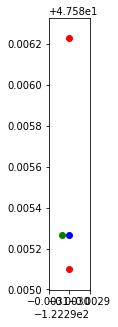

In [21]:
fig, ax = plt.subplots(figsize=(4,5))
x_max = max(adjacent_gpd.geometry.x.max(axis=0), close_gpd.geometry.x.max(axis=0))+1e-4
x_min = min(adjacent_gpd.geometry.x.min(axis=0), close_gpd.geometry.x.min(axis=0))-1e-4
y_max = max(adjacent_gpd.geometry.y.max(axis=0), close_gpd.geometry.y.max(axis=0))+1e-4
y_min = min(adjacent_gpd.geometry.y.min(axis=0), close_gpd.geometry.y.min(axis=0))-1e-4
close_gpd.plot(ax=ax, color='blue')
adjacent_gpd.plot(ax=ax, color='red')
vehicle_gpd.plot(ax=ax, color='green')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

In [22]:
adjacent_shape_pt_data

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence,shape_dist_traveled
5471,10014601,47.585098,-122.292999,19,4169.9
5473,10014601,47.586227,-122.292999,21,4580.3


In [23]:
official_shape_dist_traveled

4230.5938909265205

## now let's try with REAL data

In [23]:
base_path = ".\\data\\transformed\\map_samples"
sample_json = full_union_gpd.to_json()
with open(f'{base_path}\\close_point_sample.json', 'w') as f:
    f.write(sample_json)